In this notebook we will implement a [Duelling](https://arxiv.org/pdf/1511.06581.pdf) [Double](https://arxiv.org/pdf/1509.06461.pdf) [DQN](https://arxiv.org/pdf/1312.5602.pdf) Agent with a [Prioritized Replay Buffer](https://arxiv.org/abs/1511.05952) and n-step bootstrap. 

We will assume our observations to be arrays of shape (batch_size, height, width, channels). For the flatland environment, this can be an image of the current environment grid or the transition maps. We will first using just a picture of the environment grid as our pbservation for training a single agent. 

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

# A Sample picture of environment grid to be used as observation

In [2]:
from flatland.envs.observations import TreeObsForRailEnv, LocalObsForRailEnv, GlobalObsForRailEnv
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator
from flatland.utils.rendertools import RenderTool

In [3]:
np.random.seed(1)

# Use the complex_rail_generator to generate feasible network configurations with corresponding tasks
# Training on simple small tasks is the best way to get familiar with the environment
N_agents = 1
width = 20
height = 20
env_seed = 1

TreeObservation = TreeObsForRailEnv(max_depth=2, predictor=ShortestPathPredictorForRailEnv())
LocalGridObs = LocalObsForRailEnv(view_height=10, view_width=2, center=2)
GlobalObs = GlobalObsForRailEnv()
rail_generator = complex_rail_generator(nr_start_goal=10, nr_extra=2, min_dist=8, max_dist=99999, seed=env_seed)
env = RailEnv(width = width, height=height,
              rail_generator= rail_generator,
              schedule_generator=complex_schedule_generator(), 
              number_of_agents=N_agents, 
              obs_builder_object=GlobalObs)
env.reset()

env_renderer = RenderTool(env)

In [4]:
obs, info = env.reset()

In [5]:
env_renderer.render_env(show=False)

/home/prarit/anaconda3/envs/flatland-rl/lib/python3.6/site-packages/flatland/utils/rendertools.py:396: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


In [6]:
env_image = env_renderer.get_image()
env_image.shape

(464, 464, 4)

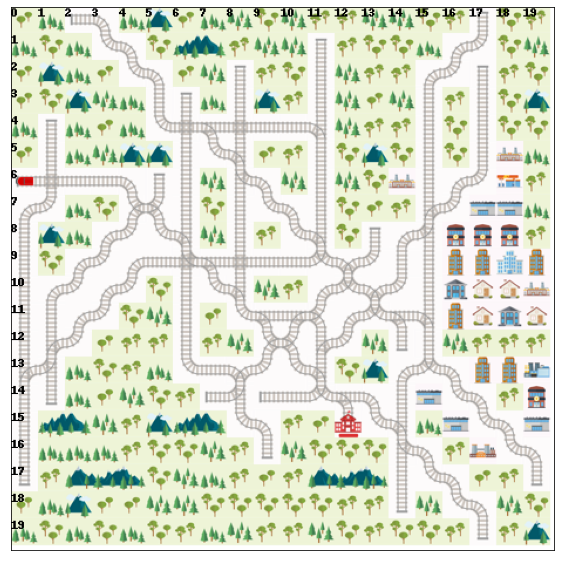

In [7]:
plt.figure(figsize = (10,10))
plt.imshow(env_image)
plt.xticks([])
plt.yticks([])
plt.show()

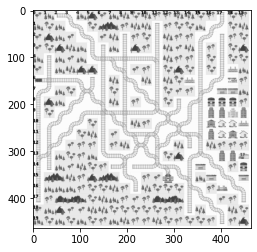

In [8]:
# gray scale image of the env
bw_image = np.mean(env_image, axis = 2)
plt.imshow(bw_image, cmap = 'gray')
plt.show()

In [9]:
obs[0][0][0,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

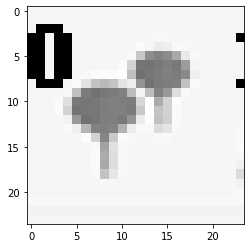

In [10]:
# gray scale image of the first cell (top-left corner) of the grid
bw_image = np.mean(env_image, axis = 2)
plt.imshow(bw_image[:24,:24], cmap = 'gray')
plt.show()

In [11]:
# destination cell
np.argwhere(obs[0][2][:,:,0]!=0)

array([[15, 12]])

In [12]:
obs[0][0][15,12]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

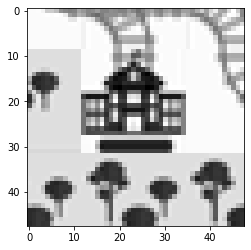

In [13]:
# gray scale image of the cell containing the destination
r = 15*24
c = 12*24
plt.imshow(bw_image[r-24:r+24,c-24:c+24], cmap = 'gray')
plt.show()

### Removing background embellishments

I think this can be done by rewriting the "env_renderer.gl.set_rail_at" method. The original definition of this method is:
   
   
     
     def set_rail_at(self, row, col, binary_trans, target=None, is_selected=False, rail_grid=None, num_agents=None,
                    show_debug=True):

        if binary_trans in self.pil_rail:
            pil_track = self.pil_rail[binary_trans]
            if target is not None:
                target_img = self.station_colors[target % len(self.station_colors)]
                target_img = Image.alpha_composite(pil_track, target_img)
                self.draw_image_row_col(target_img, (row, col), layer=PILGL.TARGET_LAYER)
                if show_debug:
                    self.text_rowcol((row + 0.8, col + 0.0), strText=str(target), layer=PILGL.TARGET_LAYER)

            city_size = 1
            if num_agents is not None:
                city_size = max(1, np.log(1 + num_agents) / 2.5)

            if binary_trans == 0:
                if self.background_grid[col][row] <= 4 + np.ceil(((col * row + col) % 10) / city_size):
                    a = int(self.background_grid[col][row])
                    a = a % len(self.lBuildings)
                    if (col + row + col * row) % 13 > 11:
                        pil_track = self.scenery[a % len(self.scenery)]
                    else:
                        if (col + row + col * row) % 3 == 0:
                            a = (a + (col + row + col * row)) % len(self.lBuildings)
                        pil_track = self.lBuildings[a]
                elif ((self.background_grid[col][row] > 5 + ((col * row + col) % 3)) or
                      ((col ** 3 + row ** 2 + col * row) % 10 == 0)):
                    a = int(self.background_grid[col][row]) - 4
                    a2 = (a + (col + row + col * row + col ** 3 + row ** 4))
                    if a2 % 64 > 11:
                        a = a2
                    a_l = a % len(self.scenery)
                    if a2 % 50 == 49:
                        pil_track = self.scenery_water[0]
                    else:
                        pil_track = self.scenery[a_l]
                    if rail_grid is not None:
                        if a2 % 11 > 3:
                            if a_l == len(self.scenery) - 1:
                                # mountain
                                if col > 1 and row % 7 == 1:
                                    if rail_grid[row, col - 1] == 0:
                                        self.draw_image_row_col(self.scenery_d2[0], (row, col - 1),
                                                                layer=PILGL.RAIL_LAYER)
                                        pil_track = self.scenery_d2[1]
                        else:
                            if a_l == len(self.scenery) - 1:
                                # mountain
                                if col > 2 and not (row % 7 == 1):
                                    if rail_grid[row, col - 2] == 0 and rail_grid[row, col - 1] == 0:
                                        self.draw_image_row_col(self.scenery_d3[0], (row, col - 2),
                                                                layer=PILGL.RAIL_LAYER)
                                        self.draw_image_row_col(self.scenery_d3[1], (row, col - 1),
                                                                layer=PILGL.RAIL_LAYER)
                                        pil_track = self.scenery_d3[2]

            self.draw_image_row_col(pil_track, (row, col), layer=PILGL.RAIL_LAYER)
        else:
            print("Illegal rail:", row, col, format(binary_trans, "#018b")[2:], binary_trans)

        if target is not None:
            if is_selected:
                svgBG = self.pil_from_png_file('flatland.png', "Selected_Target.png")
                self.clear_layer(PILGL.SELECTED_TARGET_LAYER, 0)
                self.draw_image_row_col(svgBG, (row, col), layer=PILGL.SELECTED_TARGET_LAYER)
                

         

In the above fucntion bin_trans == 0 for the cells that do not contain a rail-track and hence are empty. I think piece of code given by 

       if binary_trans == 0:
            if self.background_grid[col][row] <= 4 + np.ceil(((col * row + col) % 10) / city_size):
                a = int(self.background_grid[col][row])
                a = a % len(self.lBuildings)
                if (col + row + col * row) % 13 > 11:
                    pil_track = self.scenery[a % len(self.scenery)]
                else:
                    if (col + row + col * row) % 3 == 0:
                        a = (a + (col + row + col * row)) % len(self.lBuildings)
                    pil_track = self.lBuildings[a]
            elif ((self.background_grid[col][row] > 5 + ((col * row + col) % 3)) or
                  ((col ** 3 + row ** 2 + col * row) % 10 == 0)):
                a = int(self.background_grid[col][row]) - 4
                a2 = (a + (col + row + col * row + col ** 3 + row ** 4))
                if a2 % 64 > 11:
                    a = a2
                a_l = a % len(self.scenery)
                if a2 % 50 == 49:
                    pil_track = self.scenery_water[0]
                else:
                    pil_track = self.scenery[a_l]
                if rail_grid is not None:
                    if a2 % 11 > 3:
                        if a_l == len(self.scenery) - 1:
                            # mountain
                            if col > 1 and row % 7 == 1:
                                if rail_grid[row, col - 1] == 0:
                                    self.draw_image_row_col(self.scenery_d2[0], (row, col - 1),
                                                            layer=PILGL.RAIL_LAYER)
                                    pil_track = self.scenery_d2[1]
                    else:
                        if a_l == len(self.scenery) - 1:
                            # mountain
                            if col > 2 and not (row % 7 == 1):
                                if rail_grid[row, col - 2] == 0 and rail_grid[row, col - 1] == 0:
                                    self.draw_image_row_col(self.scenery_d3[0], (row, col - 2),
                                                            layer=PILGL.RAIL_LAYER)
                                    self.draw_image_row_col(self.scenery_d3[1], (row, col - 1),
                                                            layer=PILGL.RAIL_LAYER)
                                    pil_track = self.scenery_d3[2]
                                    
                                    
 is the part where blank spaces are filled with background scenery and buildings. I will simply comment this piece of the code in the new definition for the method. The rest will remain the same.                                    

In [14]:
import io
import os
import time
#import tkinter as tk

import numpy as np
from PIL import Image, ImageDraw, ImageFont
from numpy import array
from pkg_resources import resource_string as resource_bytes

from flatland.utils.graphics_layer import GraphicsLayer

from flatland.core.grid.rail_env_grid import RailEnvTransitions 

In [15]:
from flatland.utils.graphics_pil import PILGL, PILSVG

In [16]:
def set_rail_at_new(self, row, col, binary_trans, target=None, is_selected=False, rail_grid=None, num_agents=None,
                show_debug=True):
    
    if binary_trans in self.pil_rail:
        pil_track = self.pil_rail[binary_trans]
        if target is not None:
            target_img = self.station_colors[target % len(self.station_colors)]
            target_img = Image.alpha_composite(pil_track, target_img)
            self.draw_image_row_col(target_img, (row, col), layer=PILGL.TARGET_LAYER)
            if show_debug:
                self.text_rowcol((row + 0.8, col + 0.0), strText=str(target), layer=PILGL.TARGET_LAYER)

        city_size = 1
        if num_agents is not None:
            city_size = max(1, np.log(1 + num_agents) / 2.5)

        self.draw_image_row_col(pil_track, (row, col), layer=PILGL.RAIL_LAYER)
    else:
        print("Illegal rail:", row, col, format(binary_trans, "#018b")[2:], binary_trans)

    if target is not None:
        if is_selected:
            svgBG = self.pil_from_png_file('flatland.png', "Selected_Target.png")
            self.clear_layer(PILGL.SELECTED_TARGET_LAYER, 0)
            self.draw_image_row_col(svgBG, (row, col), layer=PILGL.SELECTED_TARGET_LAYER)

To replace the function-definition of an instance method, we follow [this](https://stackoverflow.com/questions/50599045/python-replacing-a-function-within-a-class-of-a-module) stackoverflow post as answered by Laurent H.

In [17]:
import types

In [18]:
funcType = types.MethodType
env_renderer = RenderTool(env)
env_renderer.gl.set_rail_at = funcType(set_rail_at_new, env_renderer.gl)

In [19]:
env_renderer.render_env(show=False)

In [20]:
env_image = env_renderer.get_image()
env_image.shape

(464, 464, 4)

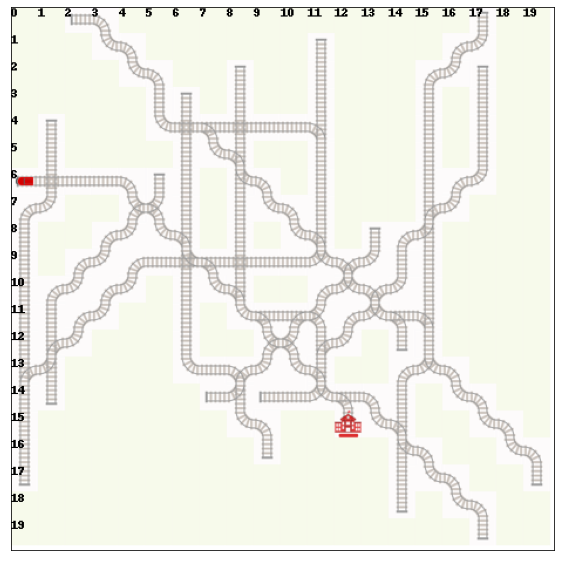

In [21]:
plt.figure(figsize = (10,10))
plt.imshow(env_image)
plt.xticks([])
plt.yticks([])
plt.show()

# The Duelling DQN Architecture

In [22]:
def NormalizedConvLayer(in_channels, out_channels, kernel_size, padding = 0, stride = 1, batch_norm = True):
    """
    Returns Convolutional Layer with batch-norm 
    """
    bias = not batch_norm
    layers = []
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = bias)
    layers.append(conv)
    if batch_norm:
        norm = nn.BatchNorm2d(out_channels)
        layers.append(norm)
    
    return nn.Sequential(*layers)   

In [23]:
class DuellingDQN(nn.Module):
    def __init__(self, in_channels, conv_dim = 32, kernel_size = 6, num_outputs = 5):
        
        super().__init__()
        
        self.in_channels = in_channels
        self.conv_dim = conv_dim
        self.kernel_size = kernel_size
        self.num_outputs = num_outputs
        
        # input is an image a 464 x 464 image
        
        self.conv1 = NormalizedConvLayer(in_channels, conv_dim, kernel_size, stride = 4, padding = 1)
        # default output shape = 32 x 116 x 116   
        
        self.conv2 = NormalizedConvLayer(conv_dim, 2*conv_dim, kernel_size, stride = 4, padding = 1)
        # default output shape = 64 x 29 x 29 
        
        self.conv3 = NormalizedConvLayer(2*conv_dim, 4*conv_dim, kernel_size, stride = 4, padding = 1)
        # default output shape = 128  x 7 x 7 
        
        self.conv4 = NormalizedConvLayer(4*conv_dim, 8*conv_dim, kernel_size = 4, stride = 2, padding = 1)
        # default output shape = 256 x 3 x 3 
        
        self.conv5 = NormalizedConvLayer(8*conv_dim, 16*conv_dim, kernel_size = 3)
        # default output shape = 512 x 1 x 1 
        
        self.value_in = nn.Linear(in_features = 16*conv_dim, out_features = 8*conv_dim, bias = False)
        self.BatchNormV = nn.BatchNorm1d(num_features = 8*conv_dim)
        self.value_out = nn.Linear(in_features = 8*conv_dim, out_features = 1)
        
        self.advantage_in = nn.Linear(in_features = 16*conv_dim, out_features = 8*conv_dim, bias = False)
        self.BatchNormA = nn.BatchNorm1d(num_features = 8*conv_dim)
        self.advantage_out = nn.Linear(in_features = 8*conv_dim, out_features = num_outputs)
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        # print(x.shape)
        x = F.selu(self.conv1(x))
        # print(x.shape)
        x = F.selu(self.conv2(x))
        # print(x.shape)
        x = F.selu(self.conv3(x))
        # print(x.shape)
        x = F.selu(self.conv4(x))
        # print(x.shape)
        x = F.selu(self.conv5(x))
        # print(x.shape)
        
        assert x.shape == (batch_size, 16*self.conv_dim, 1, 1), \
        "Wrong shape of conv5 output. Expected {}, got {}".format((batch_size, 16*self.conv_dim, 1, 1), x.size())
        
        x = x.view(batch_size, -1)
        # print(x.shape)
        
        v = F.selu(self.BatchNormV(self.value_in(x)))
        v = self.value_out(v)
        # print(v.shape)
        
        a = F.selu(self.BatchNormA(self.advantage_in(x)))
        a = self.advantage_out(a)
        # print(a.shape)
        
        mn = a.mean(dim = 1, keepdim = True)
        # print(mn.shape)
        
        return v + (a - mn)   
    
    
    def __repr__(self):
        return "DuellingDQN(in_channels = {}, conv_dim = {},"\
    " kernel_size = {}, num_outputs = {})".format(self.in_channels, self.conv_dim, self.kernel_size, self.num_outputs)

In [24]:
# testing 
batch_size = 32
dqn = DuellingDQN(in_channels = 4, kernel_size = 6)
print(dqn)
inp = torch.rand([batch_size,4, 464, 464])
print(inp.shape)
out = dqn(inp)
print(out.shape)

DuellingDQN(in_channels = 4, conv_dim = 32, kernel_size = 6, num_outputs = 5)
torch.Size([32, 4, 464, 464])
torch.Size([32, 5])


In [25]:
# kernel_size between 4 and 9 (inclusive) are allowed and do not trigger an any errors
# With other kernel size, some of the assumptions made in the design of conv4 and conv5 get violated
batch_size = 32
dqn = DuellingDQN(in_channels = 4, kernel_size = 4)
print(dqn)
inp = torch.rand([batch_size,4, 464, 464])
print(inp.shape)
out = dqn(inp)
print(out.shape)

DuellingDQN(in_channels = 4, conv_dim = 32, kernel_size = 4, num_outputs = 5)
torch.Size([32, 4, 464, 464])
torch.Size([32, 5])


In [26]:
batch_size = 32
dqn = DuellingDQN(in_channels = 4, kernel_size = 9)
print(dqn)
inp = torch.rand([batch_size,4, 464, 464])
print(inp.shape)
out = dqn(inp)
print(out.shape)

DuellingDQN(in_channels = 4, conv_dim = 32, kernel_size = 9, num_outputs = 5)
torch.Size([32, 4, 464, 464])
torch.Size([32, 5])


### The errors in the following code cells are intentional

In [27]:
# error with kernel_size = 3
batch_size = 32
dqn = DuellingDQN(in_channels = 4, kernel_size = 3)
print(dqn)
inp = torch.rand([batch_size,4, 464, 464])
print(inp.shape)
out = dqn(inp)
print(out.shape)

DuellingDQN(in_channels = 4, conv_dim = 32, kernel_size = 3, num_outputs = 5)
torch.Size([32, 4, 464, 464])


AssertionError: Wrong shape of conv5 output. Expected (32, 512, 1, 1), got torch.Size([32, 512, 2, 2])

In [28]:
# error with kernel_size = 10
batch_size = 32
dqn = DuellingDQN(in_channels = 4, kernel_size = 10)
print(dqn)
inp = torch.rand([batch_size,4, 464, 464])
print(inp.shape)
out = dqn(inp)
print(out.shape)

DuellingDQN(in_channels = 4, conv_dim = 32, kernel_size = 10, num_outputs = 5)
torch.Size([32, 4, 464, 464])


RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size